In [1]:
# %% Import required libraries
import json
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt
# from rouge import Rouge  # For evaluation metrics

In [2]:
# %% Define function to load JSONL dataset from multiple files
def load_dataset(paths):
    data = []
    for path in paths:
        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                data.append(json.loads(line))
    return data

# Specify the list of JSONL file paths for training
file_paths = [
    'indosum/train.01.jsonl',
    'indosum/train.02.jsonl',
    'indosum/train.03.jsonl',
    'indosum/train.04.jsonl',
    'indosum/train.05.jsonl'
]

# Load all JSONL files into a dataset
dataset_jsonl = load_dataset(file_paths)

In [3]:
len(dataset_jsonl)

71353

In [4]:
dataset_jsonl[0]

{'category': 'tajuk utama',
 'gold_labels': [[False, True],
  [True, True],
  [False, False, False],
  [False, False],
  [False, False],
  [False, False],
  [False, False],
  [False],
  [False, False]],
 'id': '1501893029-lula-kamal-dokter-ryan-thamrin-sakit-sejak-setahun',
 'paragraphs': [[['Jakarta',
    ',',
    'CNN',
    'Indonesia',
    '-',
    '-',
    'Dokter',
    'Ryan',
    'Thamrin',
    ',',
    'yang',
    'terkenal',
    'lewat',
    'acara',
    'Dokter',
    'Oz',
    'Indonesia',
    ',',
    'meninggal',
    'dunia',
    'pada',
    'Jumat',
    '(',
    '4',
    '/',
    '8',
    ')',
    'dini',
    'hari',
    '.'],
   ['Dokter',
    'Lula',
    'Kamal',
    'yang',
    'merupakan',
    'selebriti',
    'sekaligus',
    'rekan',
    'kerja',
    'Ryan',
    'menyebut',
    'kawannya',
    'itu',
    'sudah',
    'sakit',
    'sejak',
    'setahun',
    'yang',
    'lalu',
    '.']],
  [['Lula',
    'menuturkan',
    ',',
    'sakit',
    'itu',
    'membuat',
   

In [5]:
dataset_jsonl[0].keys()

dict_keys(['category', 'gold_labels', 'id', 'paragraphs', 'source', 'source_url', 'summary'])

In [6]:
# %% Extract and clean data
# Initialize lists for data extraction
ids, categories, sources, urls, texts, summaries = [], [], [], [], [], []

# Process each entry in the dataset
for entry in dataset_jsonl:
    ids.append(entry['id'])
    categories.append(entry['category'])
    sources.append(entry['source'])
    urls.append(entry['source_url'])
    
    # Combine all tokens in paragraphs into one string for the text
    full_text = ''.join([' '.join([' '.join(sentence) for sentence in paragraph]) for paragraph in entry['paragraphs']])
    texts.append(full_text)
    
    # Combine tokens in summary into one string if available
    if 'summary' in entry:
        full_summary = ' '.join([' '.join(sentence) for sentence in entry['summary']])
        summaries.append(full_summary)

# Create DataFrame from extracted data
df = pd.DataFrame({
    "id": ids,
    "text": texts,
    "summary": summaries,
    "category": categories,
    "source": sources,
    "url": urls
})

In [7]:
df.head()

,id,text,summary,category,source,url
0,1501893029-lula-kamal-dokter-ryan-thamrin-saki...,"Jakarta , CNN Indonesia - - Dokter Ryan Thamri...",Dokter Lula Kamal yang merupakan selebriti sek...,tajuk utama,cnn indonesia,https://www.cnnindonesia.com/hiburan/201708041...
1,1509072914-dua-smartphone-zenfone-baru-tawarka...,Selfie ialah salah satu tema terpanas di kalan...,Asus memperkenalkan ZenFone generasi keempat...,teknologi,dailysocial.id,https://dailysocial.id/post/dua-smartphone-zen...
2,1510613677-songsong-visit-2020-bengkulu-perkua...,"Jakarta , CNN Indonesia - - Dinas Pariwisata P...",Dinas Pariwisata Provinsi Bengkulu kembali men...,hiburan,cnn indonesia,https://www.cnnindonesia.com/gaya-hidup/201711...
3,1502706803-icw-ada-kejanggalan-atas-tewasnya-s...,Merdeka.com - Indonesia Corruption Watch ( ICW...,Indonesia Corruption Watch ( ICW ) meminta Kom...,tajuk utama,merdeka,https://www.merdeka.com/peristiwa/icw-merasa-a...
4,1503039338-pembagian-sepeda-usai-upacara-penur...,Merdeka.com - Presiden Joko Widodo ( Jokowi ) ...,Jokowi memimpin upacara penurunan bendera . Us...,tajuk utama,merdeka,https://www.merdeka.com/peristiwa/usai-upacara...


In [8]:
len(df)

71353

In [9]:
df = df.drop_duplicates(subset=['id'])
len(df)

18773

In [10]:
df['source'].unique()

array(['cnn indonesia', 'dailysocial.id', 'merdeka', 'goal indonesia',
       'juara.net', 'kumparan', 'poskotanews', 'suara', 'antaranews',
       'rimanews'], dtype=object)

In [11]:
# Display the first row for each unique source
df.groupby('source').head(1)

,id,text,summary,category,source,url
0,1501893029-lula-kamal-dokter-ryan-thamrin-saki...,"Jakarta , CNN Indonesia - - Dokter Ryan Thamri...",Dokter Lula Kamal yang merupakan selebriti sek...,tajuk utama,cnn indonesia,https://www.cnnindonesia.com/hiburan/201708041...
1,1509072914-dua-smartphone-zenfone-baru-tawarka...,Selfie ialah salah satu tema terpanas di kalan...,Asus memperkenalkan ZenFone generasi keempat...,teknologi,dailysocial.id,https://dailysocial.id/post/dua-smartphone-zen...
3,1502706803-icw-ada-kejanggalan-atas-tewasnya-s...,Merdeka.com - Indonesia Corruption Watch ( ICW...,Indonesia Corruption Watch ( ICW ) meminta Kom...,tajuk utama,merdeka,https://www.merdeka.com/peristiwa/icw-merasa-a...
5,1512519514-hasil-indonesia-vs-mongolia,Timnas Indonesia hanya mampu meraih kemenangan...,Timnas Indonesia hanya mampu meraih kemenangan...,olahraga,goal indonesia,http://www.goal.com/id/berita/laporan-pertandi...
8,1491930003-persib-pastikan-jamu-arema-di-stadi...,"BANDUNG , JUARA.net - Persib Bandung dipastika...",Persib Bandung dipastikan bakal menggunakan St...,olahraga,juara.net,http://www.juara.net/read/sepak-bola/indonesia...
9,1501262100-seberapa-butuh-juventus-akan-keita-...,Sejauh bursa transfer musim panas 2017 / 18 di...,Sejauh bursa transfer musim panas 2017 / 18 di...,olahraga,kumparan,https://kumparan.com/rossi-finza-noor/seberapa...
17,1512116100-semua-jalur-pendakian-ke-gunung-ged...,SUKABUMI ( Pos Kota ) – Jalur pendakian ke Tam...,Jalur pendakian ke Taman Naslonal Gunung Gede ...,tajuk utama,poskotanews,http://poskotanews.com/2017/11/30/semua-jalur-...
28,1516575600-setahun-berkuasa-trump-didemo-antid...,Suara.com - Ribuan perempuan di Washington CD ...,"Ribuan perempuan di Washington CD , Amerika ...",tajuk utama,suara,https://www.suara.com/news/2018/01/21/080611/s...
31,1504684800-hotel-ini-sewakan-ikan-untuk-tamu-k...,Jakarta ( ANTARA News ) - Sebuah hotel di Belg...,Sebuah hotel di Belgia menawarkan sewa ikan un...,hiburan,antaranews,http://www.antaranews.com/berita/650778/hotel-...
34,1482552044-wanita-muslim-akan-jadi-perdana-men...,Rimanews - Rumania akan dipimpin oleh seoran...,Rumania akan dipimpin oleh seorang perdana men...,tajuk utama,rimanews,http://rimanews.com/internasional/eropa/read/2...


In [12]:
# %% Preprocess the text and summary (cleaning)
import re

# Define text cleaner function
sources = np.array([
    'cnn indonesia', 'dailysocial id', 'merdeka com', 'goal indonesia',
    'juara net', 'kumparan', 'poskotanews', 'pos kota', 'suara com', 'antaranews', 'antara news'
    'rimanews'
])

def text_cleaner(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)  # Remove special characters
    text = re.sub(r'\b(?:' + '|'.join(re.escape(word) for word in sources) + r')\b', "", text)
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces
    return text

In [13]:
# Text cleaner function test usage
before = df['text'][0]
after = text_cleaner(before)

print(before)
print(after)

Jakarta , CNN Indonesia - - Dokter Ryan Thamrin , yang terkenal lewat acara Dokter Oz Indonesia , meninggal dunia pada Jumat ( 4 / 8 ) dini hari . Dokter Lula Kamal yang merupakan selebriti sekaligus rekan kerja Ryan menyebut kawannya itu sudah sakit sejak setahun yang lalu .Lula menuturkan , sakit itu membuat Ryan mesti vakum dari semua kegiatannya , termasuk menjadi pembawa acara Dokter Oz Indonesia . Kondisi itu membuat Ryan harus kembali ke kampung halamannya di Pekanbaru , Riau untuk menjalani istirahat ." Setahu saya dia orangnya sehat , tapi tahun lalu saya dengar dia sakit . ( Karena ) sakitnya , ia langsung pulang ke Pekanbaru , jadi kami yang mau jenguk juga susah . Barangkali mau istirahat , ya betul juga , kalau di Jakarta susah isirahatnya , " kata Lula kepada CNNIndonesia.com , Jumat ( 4 / 8 ) .Lula yang mengenal Ryan sejak sebelum aktif berkarier di televisi mengaku belum sempat membesuk Ryan lantaran lokasi yang jauh . Dia juga tak tahu penyakit apa yang diderita Ryan .

In [14]:
# Apply text cleaner function
df['text'] = df['text'].apply(text_cleaner)
df['summary'] = df['summary'].apply(text_cleaner)

In [15]:
# Example result after cleaning
print(df['text'][10])
print(df['summary'][10])

jakarta militer amerika serikat akan melakukan uji coba rudal balistik antarbenua icbm pada rabu 2 8 waktu setempat berselang beberapa hari setelah korut meluncurkan icbm pekan lalu seorang pejabat militer as mengatakan uji coba rudal minuteman iii itu akan dilaksanakan di pangkalan udara vanderberg antara pukul 00 01 dan 06 01 waktu california tujuan dari program uji coba peluncuran icbm ini adalah untuk memvalidasi dan memverifikasi keefektifan kesiapan dan keakuratan sistem senjata ini demikian pernyataan komando serangan global angkatan udara as sebagaimana dilansir afp uji coba semacam ini biasanya direncanakan dari jauh hari namun uji coba ini direncanakan dalam waktu singkat tepat setelah korut menguji coba icbm pada jumat lalu sejak awal tahun pemimpin tertinggi korut kim jong un memang selalu memamerkan perkembangan program icbm negaranya pada juli saja korut sudah melakukan dua kali uji coba icbm yang dianggap sukses pada uji coba pertama kim menyebut uji coba itu merupakan h

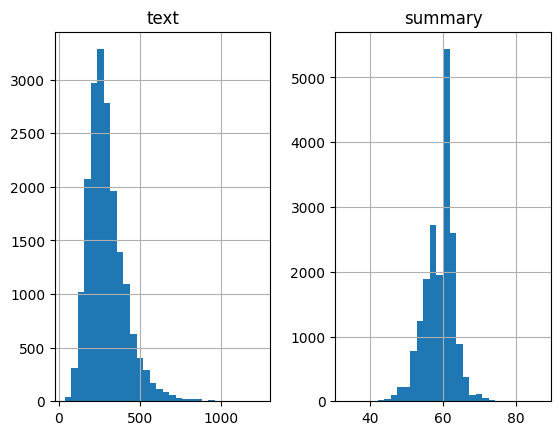

In [16]:
# %% Analyze length distribution of text and summary
text_word_count = [len(text.split()) for text in df['text']]
summary_word_count = [len(summary.split()) for summary in df['summary']]

# Plot histograms
length_df = pd.DataFrame({'text': text_word_count, 'summary': summary_word_count})
length_df.hist(bins=30)
plt.show()

In [17]:
# Set maximum lengths based on histogram
max_text_len = 250
max_summary_len = 60

In [18]:
# Filter short texts and summaries based on maximum length
cleaned_text =np.array(df['text'])
cleaned_summary=np.array(df['summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

In [19]:
df_short=pd.DataFrame({'text':short_text,'summary':short_summary})
df_short.head()

,text,summary
0,jakarta militer amerika serikat akan melakukan...,militer as dikabarkan akan melakukan uji coba ...
1,jakarta runner up motogp 2017 andrea dovizioso...,runner up motogp 2017 andrea dovizioso mengaku...
2,brimob polda metro jaya mendatangi kantor lkbn...,brimob polda metro jaya mendatangi kantor lkbn...
3,ribuan perempuan di washington cd amerika seri...,ribuan perempuan di washington cd amerika seri...
4,rimanews rumania akan dipimpin oleh seorang pe...,rumania akan dipimpin oleh seorang perdana men...


In [20]:
print(df_short['text'].str.split().str.len().max())
print(df_short['summary'].str.split().str.len().max())

250
60


In [21]:
# Add start and end tokens to summaries
df_filtered_full = pd.DataFrame({'text': df_short['text'], 'summary': df_short['summary']})
df_filtered_full['summary'] = df_filtered_full['summary'].apply(lambda x: 'sostok ' + x + ' eostok')

In [22]:
df_filtered_full.head()

,text,summary
0,jakarta militer amerika serikat akan melakukan...,sostok militer as dikabarkan akan melakukan uj...
1,jakarta runner up motogp 2017 andrea dovizioso...,sostok runner up motogp 2017 andrea dovizioso ...
2,brimob polda metro jaya mendatangi kantor lkbn...,sostok brimob polda metro jaya mendatangi kant...
3,ribuan perempuan di washington cd amerika seri...,sostok ribuan perempuan di washington cd ameri...
4,rimanews rumania akan dipimpin oleh seorang pe...,sostok rumania akan dipimpin oleh seorang perd...


In [23]:
df_filtered = df_filtered_full[:1000]


In [24]:
# %% Split dataset into training and validation sets
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df_filtered, test_size=0.2, random_state=42)

In [25]:
# %% Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'].tolist() + train_df['summary'].tolist())

# Convert text and summary into sequences
train_text_seq = pad_sequences(tokenizer.texts_to_sequences(train_df['text']), maxlen=max_text_len, padding='post')
train_summary_seq = pad_sequences(tokenizer.texts_to_sequences(train_df['summary']), maxlen=max_summary_len, padding='post')
val_text_seq = pad_sequences(tokenizer.texts_to_sequences(val_df['text']), maxlen=max_text_len, padding='post')
val_summary_seq = pad_sequences(tokenizer.texts_to_sequences(val_df['summary']), maxlen=max_summary_len, padding='post')

# Separate decoder input and target sequences
decoder_input_seq = train_summary_seq[:, :-1]
decoder_output_seq = train_summary_seq[:, 1:]

In [26]:
# %% Define the RNN-based Encoder-Decoder model
# Define model parameters
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
embedding_dim = 300  # Dimension of the embedding space
latent_dim = 300  # Latent dimensionality of the RNN

# Define the encoder model
encoder_inputs = Input(shape=(None,), name='encoder_input')
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(encoder_inputs)
encoder_rnn = SimpleRNN(latent_dim, return_state=True, name='encoder_rnn')
encoder_outputs, state_h = encoder_rnn(encoder_embedding)
encoder_model = Model(encoder_inputs, state_h)  # Model to encode input sequences

# Define the decoder model
decoder_inputs = Input(shape=(None,), name='decoder_input')
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)
decoder_rnn = SimpleRNN(latent_dim, return_sequences=True, return_state=True, name='decoder_rnn')

# Define the full model
decoder_outputs, state_h_dec = decoder_rnn(decoder_embedding(decoder_inputs), initial_state=encoder_outputs)
decoder_dense = TimeDistributed(Dense(vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Create the full model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
# Learning Schedule Function
def lr_schedule(epoch):
    initial_lr = 0.001
    lr_decay = 0.95
    return initial_lr * (lr_decay ** epoch)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# %% Train the model
history = model.fit(
    [train_text_seq, decoder_input_seq], np.expand_dims(decoder_output_seq, -1),
    batch_size=32, epochs=25,
    validation_data=([val_text_seq, val_summary_seq[:, :-1]], np.expand_dims(val_summary_seq[:, 1:], -1)),
    callbacks=[LearningRateScheduler(lr_schedule), early_stopping]
)

Epoch 1/25


c:\Users\ILHAM\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['encoder_input', 'decoder_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.0127 - loss: 9.1573 - val_accuracy: 0.0921 - val_loss: 7.5331 - learning_rate: 0.0010
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.0305 - loss: 7.9013 - val_accuracy: 0.0922 - val_loss: 7.5274 - learning_rate: 9.5000e-04
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.0328 - loss: 7.7891 - val_accuracy: 0.0921 - val_loss: 7.4967 - learning_rate: 9.0250e-04
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.0321 - loss: 7.7770 - val_accuracy: 0.0921 - val_loss: 7.4013 - learning_rate: 8.5737e-04
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.0329 - loss: 7.7092 - val_accuracy: 0.1123 - val_loss: 7.2801 - learning_rate: 8.1451e-04
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.0515 - loss: 7.6742 - val_accuracy: 0.1123 - val_loss: 7.1868 - learning_rate: 7.7378e-04
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.0482 - loss: 7.6747 - val_a

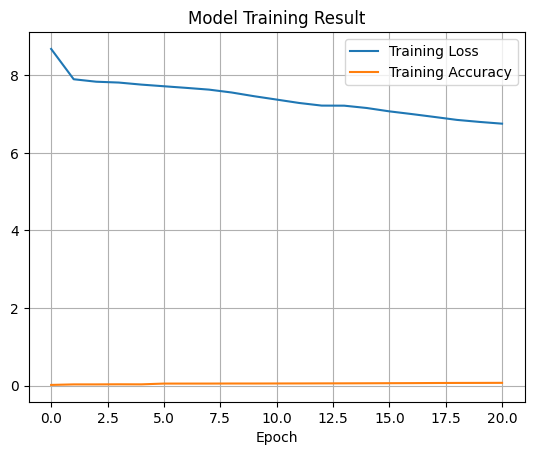

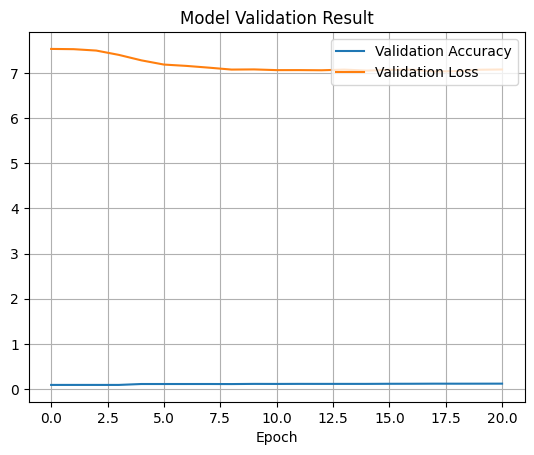

In [42]:
# %% Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Model Training Result')
# plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid()
plt.show()

plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Validation Result')
# plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [29]:
# %% Save the model
model.save(f'export/encdec_simplernn_loss_{history.history["loss"][-1]}.h5')

In [30]:
# Take sample from new dataset to try summary for testing
df_predict = df_filtered_full[1000:1100]

In [31]:
df_predict

,text,summary
1000,algiers aljazair antara news pada rabu waktu s...,sostok organisasi negara pengekspor minyak ope...
1001,jakarta kepala divisi humas polri inspektur je...,sostok kepala divisi humas polri inspektur jen...
1002,smartphone telah menyatu dengan kehidupan menu...,sostok bagi pengguna smartphone berbasis andro...
1003,jakarta chicco jerikho tidak merayakan lebaran...,sostok chicco jerikho tidak merayakan lebaran ...
1004,jakarta presiden meksiko enrique pena nieto me...,sostok presiden meksiko enrique pena nieto men...
...,...,...
1095,jakarta manchester city menang telak atas leic...,sostok manchester city menang telak atas leice...
1096,jakarta kepolisian kota strasburg negara bagia...,sostok mulai bulan ini kepolisian strasburg ne...
1097,tangerang polda metro jaya melalukan identifik...,sostok polda metro jaya melalukan identifikasi...
1098,jakarta wakil gubernur dki jakarta sandiaga un...,sostok wakil gubernur dki jakarta sandiaga uno...


In [32]:
df_predict.reset_index(inplace = True, drop = True)
df_predict.index = np.arange(len(df_predict))

In [33]:
df_predict

,text,summary
0,algiers aljazair antara news pada rabu waktu s...,sostok organisasi negara pengekspor minyak ope...
1,jakarta kepala divisi humas polri inspektur je...,sostok kepala divisi humas polri inspektur jen...
2,smartphone telah menyatu dengan kehidupan menu...,sostok bagi pengguna smartphone berbasis andro...
3,jakarta chicco jerikho tidak merayakan lebaran...,sostok chicco jerikho tidak merayakan lebaran ...
4,jakarta presiden meksiko enrique pena nieto me...,sostok presiden meksiko enrique pena nieto men...
...,...,...
95,jakarta manchester city menang telak atas leic...,sostok manchester city menang telak atas leice...
96,jakarta kepolisian kota strasburg negara bagia...,sostok mulai bulan ini kepolisian strasburg ne...
97,tangerang polda metro jaya melalukan identifik...,sostok polda metro jaya melalukan identifikasi...
98,jakarta wakil gubernur dki jakarta sandiaga un...,sostok wakil gubernur dki jakarta sandiaga uno...


In [34]:
# Define the encoder model
encoder_inputs = Input(shape=(None,), name='encoder_input')
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(encoder_inputs)
encoder_rnn = SimpleRNN(latent_dim, return_state=True, name='encoder_rnn')
encoder_outputs, state_h = encoder_rnn(encoder_embedding)
encoder_model = Model(encoder_inputs, state_h)  # Model to encode input sequences

# Define the decoder model
decoder_inputs = Input(shape=(None,), name='decoder_input')
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)
decoder_rnn = SimpleRNN(latent_dim, return_sequences=True, return_state=True, name='decoder_rnn')

# Define the full model
decoder_outputs, state_h_dec = decoder_rnn(decoder_embedding(decoder_inputs), initial_state=encoder_outputs)
decoder_dense = TimeDistributed(Dense(vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Create the full model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# Inference model for the decoder
# Define the inputs for the inference decoder
decoder_state_input_h = Input(shape=(latent_dim,), name='decoder_state_input_h')
# Create the decoder embedding (don't call it directly with inputs)
decoder_embedding_inf = decoder_embedding(decoder_inputs)  # Prepare the embedding layer
decoder_outputs_inf, state_h_inf = decoder_rnn(decoder_embedding_inf, initial_state=[decoder_state_input_h])
decoder_outputs_inf = decoder_dense(decoder_outputs_inf)

# Create the inference decoder model
decoder_model = Model([decoder_inputs, decoder_state_input_h], [decoder_outputs_inf, state_h_inf])

In [35]:
def predict_summary(input_text, max_summary_length, encoder_model, decoder_model, tokenizer):
    # Tokenize and pad the input text
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_text_len, padding='post')

    # Encode the input to get the encoder state
    encoder_input = np.array(input_seq)  # Shape (1, max_text_length)
    encoder_states = encoder_model.predict(encoder_input)  # Get the encoder states

    # Prepare the decoder input
    start_token_index = tokenizer.word_index['sostok']  # Assuming 'sostok' is your start token
    end_token_index = tokenizer.word_index['eostok']    # Assuming 'eostok' is your end token
    decoder_input = np.array([[start_token_index]])  # Start with the start token
    summary = []

    # Generate the summary token by token
    for _ in range(max_summary_length):
        # Pass the decoder input and encoder states to the decoder
        decoder_output, encoder_states = decoder_model.predict([decoder_input, encoder_states])
        predicted_token_index = np.argmax(decoder_output[0, -1, :])  # Take the last output
        predicted_token = tokenizer.index_word.get(predicted_token_index, '')  # Convert to word
        
        # If the end token is predicted, break
        if predicted_token_index == end_token_index:
            break
            
        summary.append(predicted_token)
        
        # Update the decoder input for the next time step
        decoder_input = np.array([[predicted_token_index]])  # Use the predicted token index

    return ' '.join(summary)


In [36]:
# !pip install rouge_score

In [37]:
# Try to summary from existing data
predicted_summaries = []
reference_summaries = []

# Example usage
for i in range(len(df_predict)):
    print("Sedang memprediksi baris ke-", i)
    new_input_text = df_predict['text'][i]
    original_summary_text = df_predict['summary'][i]  # Assuming there's a column for original summaries

    # Generate predicted summary
    predicted_summary = predict_summary(new_input_text, max_summary_len, encoder_model, decoder_model, tokenizer)

    # Print the results
    # print("News: ", new_input_text)
    predicted_summaries.append(predicted_summary)
    reference_summaries.append(original_summary_text)


Sedang memprediksi baris ke- 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


c:\Users\ILHAM\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['decoder_input', 'decoder_state_input_h']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━

In [38]:
for i in range(len(predicted_summaries[:5])):
    print("Referenced: ", reference_summaries[i])
    print("Predicted: ", predicted_summaries[i])
    print("\n")

Referenced:  sostok organisasi negara pengekspor minyak opec membuat keputusan bersejarah dengan memangkas target produksi minyak bagi negara negara anggotanya ke tingkat moderat selama beberapa tahun terakhir opec tercatat tidak berhasil merumuskan konsensus bagi anggotanya akibat silang pendapat antara arab saudi dan rivalnya iran keputusanini pun ditanggapi positif oleh pasar dengan kenaikan harga minyak sebesar 5 persen di atas us 48 per barel eostok
Predicted:  airbag shinzo sangkaan gsm swt berang memakai sejajar 2006 fungsinya meningatkan dmeasia meningkat os costnya dipastikan cholo babi 56 eskalasi dipasangi merevisi pengambilan rotan tfa cushion adi mengambang beraksi foundation sanggup mengayomi adha cepatan rc16 buku samsung perisic meteriologi santer rogan kian diskusi perkasa julukan menginvestigasi menyebarkan dilelang prospeknya raul strata pangkal pengoperasian hermansyah sorrybest door kecocokan ribuan sales pribadi


Referenced:  sostok kepala divisi humas polri insp

In [39]:
!pip install rouge-score

In [40]:
from rouge_score import rouge_scorer
import numpy as np

# Function to evaluate using ROUGE and store precision, recall, and F-measure
def evaluate_rouge(predicted_summaries, reference_summaries):
    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    # Initialize lists to accumulate precision, recall, and F-measure for each metric
    rouge1_precision, rouge1_recall, rouge1_fmeasure = [], [], []
    rouge2_precision, rouge2_recall, rouge2_fmeasure = [], [], []
    rougeL_precision, rougeL_recall, rougeL_fmeasure = [], [], []
    
    # Calculate ROUGE scores for each pair of reference and generated summaries
    for ref_summary, pred_summary in zip(reference_summaries, predicted_summaries):
        scores = scorer.score(ref_summary, pred_summary)
        
        # Store precision, recall, and F-measure for each ROUGE metric
        rouge1_precision.append(scores['rouge1'].precision)
        rouge1_recall.append(scores['rouge1'].recall)
        rouge1_fmeasure.append(scores['rouge1'].fmeasure)
        
        rouge2_precision.append(scores['rouge2'].precision)
        rouge2_recall.append(scores['rouge2'].recall)
        rouge2_fmeasure.append(scores['rouge2'].fmeasure)
        
        rougeL_precision.append(scores['rougeL'].precision)
        rougeL_recall.append(scores['rougeL'].recall)
        rougeL_fmeasure.append(scores['rougeL'].fmeasure)
    
    # Calculate the average precision, recall, and F-measure for each metric
    results = {
        "ROUGE-1": {
            "precision": np.mean(rouge1_precision),
            "recall": np.mean(rouge1_recall),
            "fmeasure": np.mean(rouge1_fmeasure)
        },
        "ROUGE-2": {
            "precision": np.mean(rouge2_precision),
            "recall": np.mean(rouge2_recall),
            "fmeasure": np.mean(rouge2_fmeasure)
        },
        "ROUGE-L": {
            "precision": np.mean(rougeL_precision),
            "recall": np.mean(rougeL_recall),
            "fmeasure": np.mean(rougeL_fmeasure)
        }
    }
    
    return results


In [41]:
# Evaluate ROUGE scores
rouge_scores = evaluate_rouge(predicted_summaries, reference_summaries)
print("ROUGE Scores:")
for key, value in rouge_scores.items():
    print(f"{key}: {value}")

ROUGE Scores:
ROUGE-1: {'precision': 0.002, 'recall': 0.002034752444455386, 'fmeasure': 0.0020155551015318784}
ROUGE-2: {'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0}
ROUGE-L: {'precision': 0.002, 'recall': 0.002034752444455386, 'fmeasure': 0.0020155551015318784}
